# Example: CEST

In [1]:
# git clone https://github.com/alsinmr/pyRelaxSim.git
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
sys.path.append('/Users/albertsmith/Documents/GitHub')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt

## Build the spin-system 

In [21]:
ex=RS.ExpSys(v0H=600,Nucs='13C',T_K=298)
ex.set_inter(Type='CS',i=0,ppm=-10)
ex1=ex.copy()
ex1.set_inter(Type='CS',i=0,ppm=10)

## Calculate the Liouvillian with exchange, add T1, T2 relaxation

In [43]:
kex=np.array([[-1e1,1e3],[1e1,-1e3]])
L=RS.Liouvillian((ex,ex1),kex=kex)
L.add_relax(Type='T1',i=0,T1=1.5,Peq=True)
L.add_relax(Type='T2',i=0,T2=.1)
d,v=np.linalg.eig(kex)
pop=v[:,np.argmin(np.abs(d))]
pop/=pop.sum()
print(f'Normalized populations are {pop}')

Normalized populations are [0.99009901 0.00990099]


## Saturation propagators (sweep $\nu_{off}$), Upi/2, Uprop

In [44]:
U=list()
voff0=np.linspace(-3000,3000,200)
for voff in voff0:
    L.fields['13C']=(200,0,voff)
    U.append(L.U(tf=.2))
    
L.fields['13C']=(100000,np.pi/2,0)
Upi2=L.U(t0=0,tf=2.5e-6)
L.fields['13C']=(0,0,0)
Uprop=L.U(t0=0,tf=1/6000)


## Prepare and propagate the system at each offset

In [45]:
rho=RS.Rho(rho0='13Cz',detect='13Cp',L=L)
I=list()
for U0 in U:
    rho.clear()
    Upi2*U0*rho
    rho.DetProp(Uprop,n=1024)
    I.append(rho.FT[0].real)
    

## Plot a few of the spectra

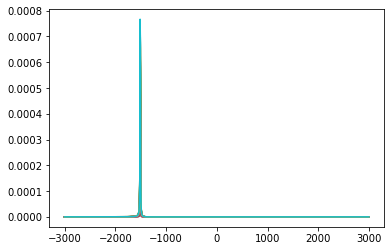

In [46]:
ax=plt.figure().add_subplot(111)
for I0 in I[::10]:
    ax.plot(rho.v_axis,I0)

In [47]:
S=np.array([I0.sum() for I0 in I])

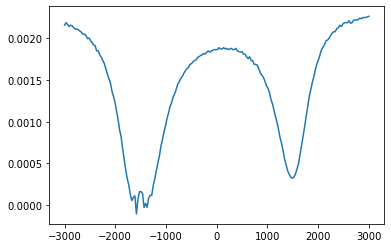

In [48]:
ax=plt.figure().add_subplot(111)
ax.plot(voff0,S)

## Same as above, but with CSA tensor

In [86]:
ex=RS.ExpSys(v0H=600,vr=5000,Nucs='13C',T_K=298,pwdavg=RS.PowderAvg(q=2))
ex.set_inter(Type='CS',i=0,ppm=-10)
ex.set_inter(Type='CSA',i=0,delta=10000)
ex1=ex.copy()
ex1.set_inter(Type='CS',i=0,ppm=10)

In [87]:
kex=np.array([[-1e1,1e3],[1e1,-1e3]])
L=RS.Liouvillian((ex,ex1),kex=kex)
L.add_relax(Type='T1',i=0,T1=1.5,Peq=True)
L.add_relax(Type='T2',i=0,T2=.1)
d,v=np.linalg.eig(kex)
pop=v[:,np.argmin(np.abs(d))]
pop/=pop.sum()
print(f'Normalized populations are {pop}')

Normalized populations are [0.99009901 0.00990099]


## Same as before, but with attention to retain rotor syncronization

In [88]:
U=list()
voff0=np.linspace(-3000,3000,40)
for voff in voff0[:1]:
    voff=-10*600/4
    L.fields['13C']=(200,0,voff)
    U.append(L.U()**1000)

L.fields['13C']=(0,0,0)    
seq=RS.Sequence(L)
seq.add_channel('13C',v1=[100000,0],t=[0,2.5e-6],phase=[np.pi/2,0])
Upi2=seq.U(t0=0,tf=2.5e-6)
Uprop=L.U(t0=2.5e-6,tf=L.taur+2.5e-6)

## Prepare and propagate the system at each offset

In [91]:
rho=RS.Rho(rho0='13Cz',detect='13Cp',L=L)
I=list()
for U0 in U:
    rho.clear()
    Upi2*rho
    rho.DetProp(Uprop,n=1024)
    I.append(rho.FT[0].real)
    

## Plot a few of the spectra

In [96]:
Upi2.Dt

2.5e-06

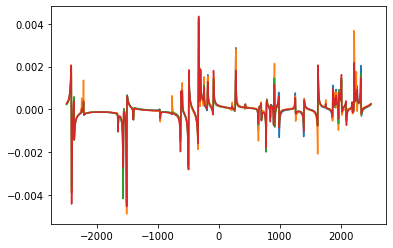

In [74]:
ax=plt.figure().add_subplot(111)
for I0 in I[::10]:
    ax.plot(rho.v_axis,I0)

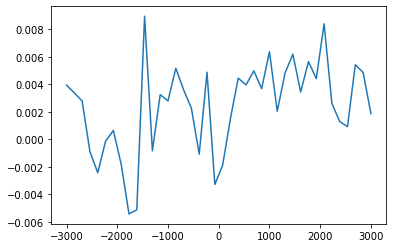

In [75]:
S=np.array([I0.sum() for I0 in I])
ax=plt.figure().add_subplot(111)
ax.plot(voff0,S)

<AxesSubplot:xlabel='$\\nu$ / kHz', ylabel='I / a.u.'>

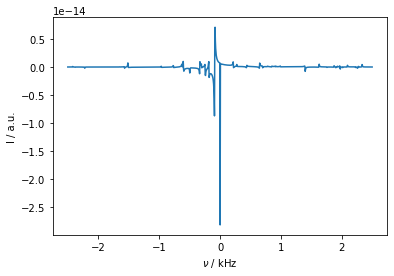

In [97]:
seq=RS.Sequence(L)
seq.add_channel('13C',v1=[100000,0],t=[0,2.5e-6],phase=[np.pi/2,0])
Upi2=seq.U(t0=0,tf=2.5e-6)
U=L.U(t0=2.5e-6,tf=L.taur+2.5e-6)

rho=RS.Rho(rho0='13Cz',detect='13Cp',L=L)
Upi2*rho.DetProp(U,n=1024)
rho.plot(FT=True,imag=False)

In [100]:
L.Lex

array([[  -10.,    -0.,    -0.,    -0.,  1000.,     0.,     0.,     0.],
       [   -0.,   -10.,    -0.,    -0.,     0.,  1000.,     0.,     0.],
       [   -0.,    -0.,   -10.,    -0.,     0.,     0.,  1000.,     0.],
       [   -0.,    -0.,    -0.,   -10.,     0.,     0.,     0.,  1000.],
       [   10.,     0.,     0.,     0., -1000.,    -0.,    -0.,    -0.],
       [    0.,    10.,     0.,     0.,    -0., -1000.,    -0.,    -0.],
       [    0.,     0.,    10.,     0.,    -0.,    -0., -1000.,    -0.],
       [    0.,     0.,     0.,    10.,    -0.,    -0.,    -0., -1000.]],
      dtype=float32)

In [101]:
Upi2.expsys

1-spin system (13C)
B0 = 14.092 T (600.000 MHz 1H frequency)
rotor angle = 54.736 degrees
rotor frequency = 5.0 kHz
Temperature = 298 K
Powder average with 49 angles, 100 steps per rotor period
Interactions:
	CS on spin 0 with arguments: (ppm=-10)
	CSA on spin 0 with arguments: (delta=10000)